In [1]:
import torch
import sys
import yaml
from torchvision import transforms
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob

sys.path.append('../')
from models.resnet_base_network import ResNet18

# Config & Device
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([transforms.ToTensor()])

config = yaml.load(open("../config/config.yaml", "r"), Loader=yaml.FullLoader)

# Unlabeled Dataset
class UnlabeledImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.paths = glob.glob(os.path.join(root, "*.jpg")) + glob.glob(os.path.join(root, "*.jpeg"))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.paths[idx])  # return filename for reference

# Single folder with all images
data_dir = "/nmhs2/prema/imageprocessing/paddy_images"
dataset = UnlabeledImageDataset(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load BYOL encoder
encoder = ResNet18(**config['network'])
load_params = torch.load(
    '/nmhs2/prema/imageprocessing/byol/PyTorch-BYOL/runs/byol_experiment/checkpoints/model.pth',
    map_location=device
)
if 'online_network_state_dict' in load_params:
    encoder.load_state_dict(load_params['online_network_state_dict'])
    print("BYOL weights loaded")

encoder = torch.nn.Sequential(*list(encoder.children())[:-1])
encoder = encoder.to(device)

# Feature Extraction
def get_features_from_encoder(encoder, loader):
    features = []
    filenames = []
    encoder.eval()
    with torch.no_grad():
        for imgs, names in loader:
            imgs = imgs.to(device)
            feat = encoder(imgs)
            if len(feat.shape) > 2:
                feat = torch.mean(feat, dim=[2, 3])  # flatten spatial dims
            features.append(feat.cpu())
            filenames.extend(names)
    return torch.cat(features, dim=0), filenames

features, filenames = get_features_from_encoder(encoder, loader)

print("Features shape:", features.shape)

# Save features and filenames
save_dir = "/nmhs2/prema/imageprocessing/byol/feature_byol"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "all_features.npy"), features.numpy())
np.save(os.path.join(save_dir, "all_filenames.npy"), np.array(filenames))

print(f"✅ Saved all_features.npy and all_filenames.npy to {save_dir}")


/home/prema/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prema/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3887536/994432479.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This l

BYOL weights loaded
Features shape: torch.Size([3430, 512])
✅ Saved all_features.npy and all_filenames.npy to /nmhs2/prema/imageprocessing/byol/feature_byol


/tmp/ipykernel_3887536/3438187483.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


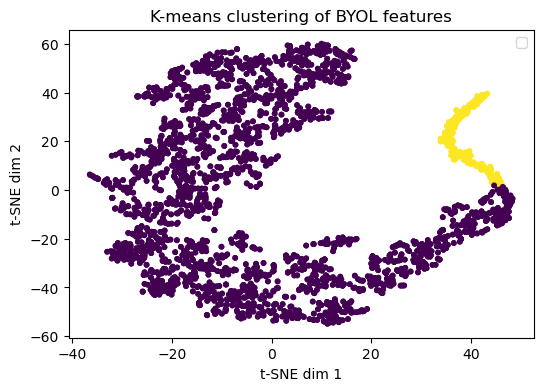

In [7]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load features if not already in memory
# features = np.load("/nmhs2/prema/imageprocessing/byol/features/all_features.npy")
# filenames = np.load("/nmhs2/prema/imageprocessing/byol/features/all_filenames.npy", allow_pickle=True)

# Convert to numpy
X = features.numpy() if torch.is_tensor(features) else features

# Step 1: Apply K-means
num_clusters = 2  # e.g., diseased vs nondiseased
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Step 2: Reduce dimensions for visualization (PCA or t-SNE)
pca = PCA(n_components=50, random_state=42)  # first reduce to 50 dims for speed
X_reduced = pca.fit_transform(X)

# Optional: t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_reduced)

# Step 3: Plot
plt.figure(figsize=(6, 4))
for i in range(num_clusters):
   plt.scatter(x_train_tsne[:,0], x_train_tsne[:,1], c=train_clusters, cmap="viridis", s=10)
plt.legend()
plt.title("K-means clustering of BYOL features")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()


✅ Total matched images: 2871


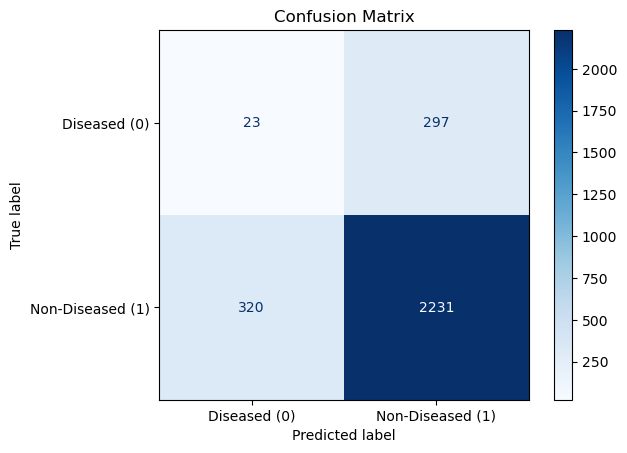

✅ Accuracy: 0.7851


In [11]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# Path to actual labeled data
label_dir = "/nmhs2/prema/imageprocessing/paddy_csir/data_for_confusion_matrix"

# Load all images and create a label dictionary
label_dict = {}
for label_name, label_value in [("diseased", 0), ("nondiseased", 1)]:
    folder = os.path.join(label_dir, label_name)
    for img_file in os.listdir(folder):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            label_dict[img_file] = label_value

# Prepare ground truth labels based on filenames
true_labels = []
matched_filenames = []

for fname in filenames:
    if fname in label_dict:
        true_labels.append(label_dict[fname])
        matched_filenames.append(fname)

true_labels = np.array(true_labels)

# Align corresponding cluster labels (same order as matched filenames)
# We only keep cluster labels for the matched images
matched_clusters = []
for fname in matched_filenames:
    idx = filenames.index(fname)
    matched_clusters.append(cluster_labels[idx])

matched_clusters = np.array(matched_clusters)

print(f"✅ Total matched images: {len(matched_filenames)}")

# Step 3: Align clusters using Hungarian algorithm
cm_raw = confusion_matrix(true_labels, matched_clusters)
row_ind, col_ind = linear_sum_assignment(-cm_raw)
mapping = dict(zip(col_ind, row_ind))
aligned_clusters = np.array([mapping[c] for c in matched_clusters])

# Step 4: Final confusion matrix after alignment
cm_aligned = confusion_matrix(true_labels, aligned_clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aligned,
                              display_labels=["Diseased (0)", "Non-Diseased (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Optional: print metrics
accuracy = np.trace(cm_aligned) / np.sum(cm_aligned)
print(f"✅ Accuracy: {accuracy:.4f}")
